# Predição de séries temporais de carga elétrica
Este notebook coleta, organiza e visualiza dados públicos da ENTSO‑E para construir conjuntos de treino e avaliação de modelos de previsão temporal.
Autor: Victor Mario Bertini (RA: 194761)

# Capítulo 1 — Coleta de dados
Nesta etapa baixamos dados da ENTSO‑E via API REST e salvamos em formato Parquet dentro da pasta `data/`. O objetivo é permitir reexecuções parciais: cada subetapa persiste artefatos para evitar refazer todo o fluxo.
Fonte: https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html
Escopo desta versão do notebook:
- Países europeus selecionados (FR, ES, PT - França,  Espanha, Portugal)
- Dataset principal:
  - Load — Actual Total (carga realizada agregada)
- Período: até 180 dias retroativos
Subcapítulos desta etapa:
1. Coleta e salvamento bruto (Parquet)
2. Visualização exploratória (carga)
3. Preparação de dados para treino

## Dependências

In [13]:
# Checagem/instalação leve de dependências
print("Verificando dependências (pyarrow para Parquet)...")

try:
    import pyarrow as pa
    print(f"PyArrow disponível: {pa.__version__}")
except Exception:
    print("Instalando pyarrow...")
    !pip install --upgrade "pyarrow>=18" --quiet
    import importlib
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"PyArrow instalado: {pa.__version__}")

# fastparquet é opcional
try:
    import fastparquet  # noqa: F401
    print("fastparquet disponível (opcional)")
except Exception:
    pass

# Outras bibliotecas sob demanda
for lib in [
    "numpy", "python-dotenv", "pandas", "matplotlib", "seaborn",
    "scikit-learn", "tensorflow", "keras", "lxml", "pytz", "requests", "optuna"
]:
    try:
        __import__(lib)
    except ImportError:
        print(f"Instalando {lib}...")
        !pip install {lib} --quiet

print("Dependências prontas")

Verificando dependências (pyarrow para Parquet)...
PyArrow disponível: 22.0.0
Instalando python-dotenv...
Instalando scikit-learn...
Instalando scikit-learn...
Dependências prontas
Dependências prontas


## Coleta de dados brutos

In [14]:
# Imports para a API e utilidades
import os
import requests
import pandas
from dotenv import load_dotenv
from datetime import datetime, timedelta, date
import pytz
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Carregar variáveis de ambiente do .env
load_dotenv()

True

### Definição de funções de coleta de dados e de salvamento em parquet

In [15]:
import os
import re
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import requests
from lxml import etree

# ---------------- CONFIG ---------------- #
COUNTRY_DOMAINS = {
    "FR": {"domain": "10YFR-RTE------C"},
    "ES": {"domain": "10YES-REE------0"},
    "PT": {"domain": "10YPT-REN------W"}
}

# Apenas carga (Load — Actual Total)
DATA_ITEMS = [
    {'key': 'load_total', 'documentType': 'A65', 'processType': 'A16', 'domainParam': 'outBiddingZone_Domain', 'parser': 'load'}
]

ENTSOE_TOKEN = os.environ.get("ENTSOE_SECURITY_TOKEN")
BASE_URL = "https://web-api.tp.entsoe.eu/api"
MAX_WORKERS = 100
RAW_DIR = os.path.join("data", "raw")
PARQUET_COMPRESSION = "zstd"
os.makedirs(RAW_DIR, exist_ok=True)

# ---------------- HELPERS ---------------- #
def build_params(item, domain, start_dt, end_dt):
    """Build API query parameters for load (A65)."""
    return {
        "securityToken": ENTSOE_TOKEN,
        "documentType": item['documentType'],
        "processType": item['processType'],
        "periodStart": start_dt.strftime("%Y%m%d%H%M"),
        "periodEnd": end_dt.strftime("%Y%m%d%H%M"),
        item['domainParam']: domain,
    }

def parse_xml_points(xml_bytes: bytes, parser_type: str) -> pd.DataFrame:
    """Parse ENTSO-E XML response into a DataFrame with proper datetime (load only)."""
    if parser_type != "load":
        return pd.DataFrame()
    root = etree.fromstring(xml_bytes)
    period_elem = root.find(".//{*}Period")
    if period_elem is None:
        return pd.DataFrame()

    start_elem = period_elem.find("{*}timeInterval/{*}start")
    period_start = start_elem.text if start_elem is not None else None

    res_elem = period_elem.find("{*}resolution")
    resolution = res_elem.text if res_elem is not None else None

    rows = []
    for point in period_elem.findall("{*}Point"):
        pos_elem = point.find("{*}position")
        if pos_elem is None or pos_elem.text is None:
            continue
        pos = int(pos_elem.text)

        val_elem = point.find("{*}quantity")
        if val_elem is None or val_elem.text is None:
            continue
        rows.append({
            'position': pos,
            'quantity_MW': float(val_elem.text),
            'period_start': period_start,
            'resolution': resolution
        })

    df = pd.DataFrame(rows)
    
    if not df.empty and 'period_start' in df.columns and 'resolution' in df.columns:
        # extract minutes from resolution string (positions 2:4)
        df['minutes'] = df['resolution'].str[2:4].astype(int)
        df['datetime'] = pd.to_datetime(df['period_start'], utc=True) + pd.to_timedelta((df['position'] - 1) * df['minutes'], unit='minutes')
        df.drop(columns=['minutes'], inplace=True)
    
    return df

def fetch_day(session, item, country, day: datetime, retries=3, delay=5):
    """Fetch a single day of load data for a given country."""
    domain = COUNTRY_DOMAINS[country]['domain']
    start_dt = day
    end_dt = start_dt + timedelta(days=1)
    params = build_params(item, domain, start_dt, end_dt)

    for attempt in range(retries):
        try:
            r = session.get(BASE_URL, params=params, timeout=30)
            r.raise_for_status()
            df = parse_xml_points(r.content, item['parser'])
            if df.empty:
                return pd.DataFrame()
            df['country'] = country
            return df
        except (requests.exceptions.RequestException, etree.XMLSyntaxError) as e:
            print(f"[WARNING] Attempt {attempt+1} failed for {country} {item['key']} {day}: {e}")
            time.sleep(delay * (2 ** attempt))
    return pd.DataFrame()

def daterange(start: datetime, end: datetime):
    """Yield datetime objects for each day between start and end, inclusive of start, exclusive of end."""
    current = start
    while current < end:
        yield current
        current += timedelta(days=1)

def fetch_last_days(lookback_days: int, reference_datetime: datetime = None) -> pd.DataFrame:
    """
    Fetch ENTSO-E load data for the last `lookback_days` days, rounding reference time down to the previous full hour.
    """
    if reference_datetime is None:
        reference_datetime = datetime.now()

    # Round down to previous hour
    end_dt = reference_datetime.replace(minute=0, second=0, microsecond=0)
    start_dt = end_dt - timedelta(days=lookback_days)

    print(f"[INFO] Fetching data from {start_dt} to {end_dt} (rounded to hour)")

    all_dfs = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        with requests.Session() as session:
            for item in DATA_ITEMS:
                for country in COUNTRY_DOMAINS:
                    for single_day in daterange(start_dt, end_dt):
                        futures.append(executor.submit(fetch_day, session, item, country, single_day))
            for f in as_completed(futures):
                df = f.result()
                if not df.empty:
                    all_dfs.append(df)

    if all_dfs:
        merged = pd.concat(all_dfs, ignore_index=True)
        merged = merged.pivot_table(index=['datetime', 'country'],
                                    values=['quantity_MW'],
                                    aggfunc='first').reset_index()
        merged['quantity_MW'] = merged.groupby('country')['quantity_MW'].ffill()

        # ==========================================
        # 🔽 Downsample to hourly datetimes (H over H)
        # ==========================================
        merged['datetime'] = pd.to_datetime(merged['datetime'], utc=True)

        merged = (
            merged
            .set_index('datetime')
            .groupby('country', group_keys=False)
            .resample('1H')
            .first()
            .reset_index()
        )

        # ==========================================
        # Save hourly-parquet dataset
        # ==========================================
        filename = "raw_dataset.parquet"
        path = os.path.join(RAW_DIR, filename)
        merged.to_parquet(path, engine="pyarrow",
                          compression=PARQUET_COMPRESSION, index=False)
        print(f"[INFO] Saved merged hourly data to {path}")
        return merged

    else:
        return pd.DataFrame(columns=['datetime', 'country', 'quantity_MW'])


## Coletando dados
Nesta seção buscamos dados históricos de carga (A65). O período é exclusivamente passado (até ontem):
- Carga (A65): outBiddingZone_Domain = <EIC do país>
Os resultados serão salvos como arquivos Parquet em `data/` para reutilização nas próximas etapas.

In [16]:
lookback_days = 365*4
df = fetch_last_days(lookback_days)

[INFO] Fetching data from 2021-11-04 21:00:00 to 2025-11-03 21:00:00 (rounded to hour)
[WARNING] Attempt 1 failed for ES load_total 2024-11-04 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for ES load_total 2024-10-26 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for ES load_total 2024-09-26 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for ES load_total 2024-09-28 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for ES load_total 2024-10-09 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
[WARNING] Attempt 1 failed for ES load_total 2024-11-04 21:00:00: ('Connection aborted.', RemoteDisconnected('Remote e

/tmp/ipykernel_110275/1631035937.py:154: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')
/tmp/ipykernel_110275/1631035937.py:155: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .first()


## Visualização dos dados

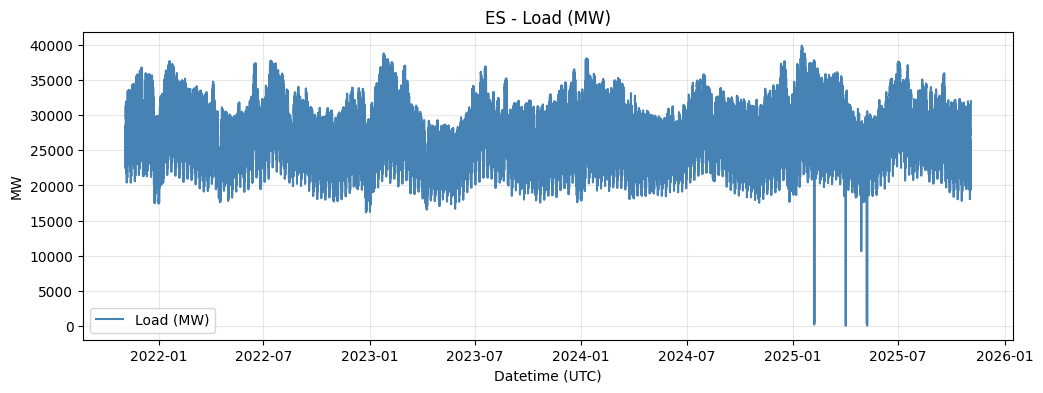

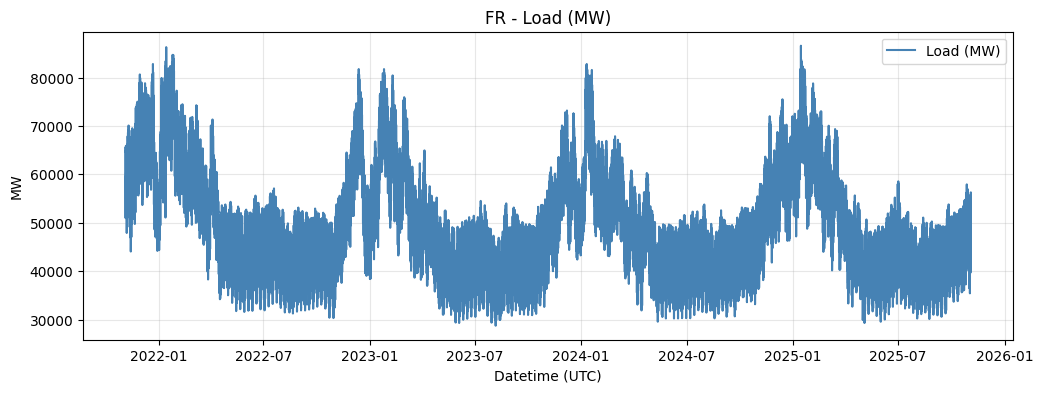

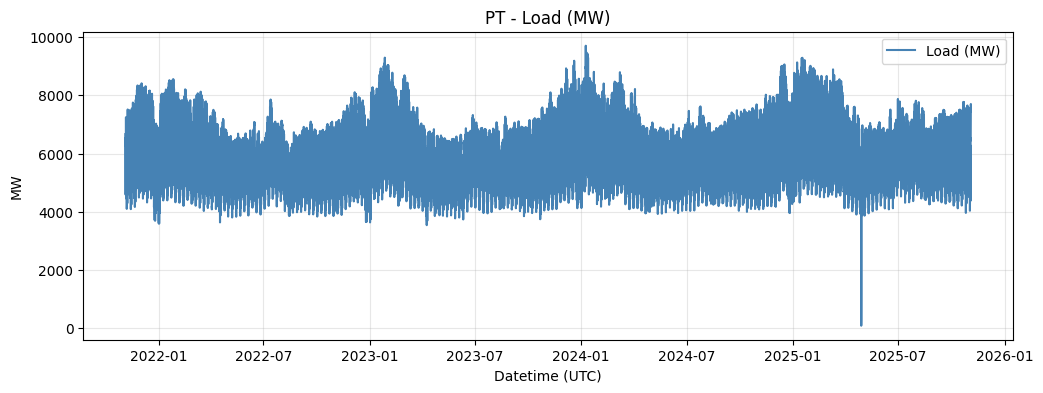

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved hourly parquet and plot only Load (MW)
path = os.path.join("data", "raw", "raw_dataset.parquet")

if not os.path.exists(path):
    print(f"Parquet not found at {path}. Run fetch_last_days() first to create it.")
else:
    df = pd.read_parquet(path)
    if df.empty:
        print("No data available to plot. Run fetch_last_days first.")
    elif 'country' not in df.columns or 'datetime' not in df.columns or 'quantity_MW' not in df.columns:
        print("Parquet is missing required columns: 'country', 'datetime', 'quantity_MW'.")
    else:
        # Normalize types and drop invalids
        df = df.copy()
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
        df = df[df['datetime'].notna()]
        # Build a safe sorted list of countries (strings only)
        countries = sorted(map(str, pd.unique(df['country'].dropna())))
        if not countries:
            print("No countries available to plot after filtering nulls.")
        else:
            for country in countries:
                sub = df[df['country'].astype(str) == country].sort_values('datetime')
                if sub.empty:
                    continue
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(sub['datetime'], sub['quantity_MW'], color='steelblue', label='Load (MW)')
                ax.set_title(f'{country} - Load (MW)')
                ax.set_xlabel('Datetime (UTC)')
                ax.set_ylabel('MW')
                ax.grid(True, alpha=0.3)
                ax.legend()
                plt.show()

## Capítulo 2 — Definição dos Problemas (Previsão de Carga)

Três níveis progressivos de complexidade.  
Dados horários (1 passo = 1 hora).  
Target: **carga elétrica (A65)**.  
Modelos: **Linear, MLP, LSTM, TFT**.

---

### 🔹 Nível 1 — Um País (Série Univariada por País)

| Variante | Lookback (entrada) | Horizonte (lead) | País | Saída (shape) |
|---|---|---|---|---|
| **A** | 2 dias = **168** passos | 1 dia = **24** passos | AT | (N, 24, 1) |
| **B** | 7 dias = **360** passos | 2 dias = **72** passos | AT | (N, 72, 1) |
| **C** | 10 dias = **720** passos | 3 dias = **168** passos | AT | (N, 168, 1) |

**Regra:**  
Treine sempre com o **lookback máximo (C)** e avalie versões A/B reduzindo a janela no *dataset* (sem precisar re‐treinar o modelo).  
- **LSTM/TFT:** aceitam `(batch, seq_len_reduzido, n_feats)` naturalmente.  
- **Linear/MLP:** precisam de padding até o `seq_len_max` com valor **-999.0**, mascarado ou zerado via camada Lambda.

---

### 🔹 Nível 2 — Múltiplos Países (Séries Agrupadas)

| Variante | Lookback | Horizonte | Países | Saída (shape) |
|---|---|---|---|---|
| **A** | 3d (168) | 1d (24) | ES, PT, FR | (N, 24, 1) |
| **B** | 7d (360) | 2d (72) | ES, PT, FR | (N, 72, 1) |
| **C** | 10d (720) | 3d (168) | ES, PT, FR | (N, 168, 1) |

**Estrutura:**  
Cada país é identificado por `_group_id = country`, com `time_idx` sequencial por grupo.  
O treino e avaliação seguem a mesma regra do Nível 1 — treinar no máximo e avaliar em versões reduzidas.

---

### 🔹 Nível 3 — Robustez a Ruído (Extensão do Nível 2)

Objetivo: medir a **robustez** do modelo frente a perturbações nos dados de entrada.

O ruído é aplicado **apenas no Nível 2** (cenário multi-país), simulando leituras ruidosas ou inconsistentes.

\[
X_{ruidoso} = X + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\]

**Configuração:**
- Aplicar **após normalização** dos dados.
- Não alterar o dataset de treino — apenas **teste**.
- Intensidades de ruído:
  - σ ∈ {0.00, 0.01, 0.03, 0.05, 0.10}

**Aplicação por arquitetura:**
- **LSTM/TFT:** adicione ruído ao tensor `(batch, seq_len, n_features)` antes do forward.  
- **Linear/MLP:** adicione ruído ao vetor achatado após o padding/máscara.

**Métrica:**  
Avaliar degradação (MAE, MSE) com o aumento de σ.  
Gerar curvas de **erro vs ruído** para comparar arquiteturas.

---

### 🔹 Builders e Pipeline de Dados

- **Fonte:** Parquets em `data/`.
- **Passo temporal:** 1 hora.
- Cada amostra (por país):
  ```python
  X.shape = (seq_len, n_features)
  Y.shape = (lead, 1)
